# Topic 6: Simple Topic Modeling - SOLUTIONS

Complete solutions for Topic Modeling exercises using LDA and other techniques.

**Note:** If you encounter numpy/gensim compatibility errors, run:
```bash
pip install --upgrade numpy gensim
# or use a compatible version:
# pip install gensim==4.1.2
```

This notebook includes fallback implementations using scikit-learn when gensim is not available.

In [1]:
# Essential imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Try to import advanced libraries
try:
    from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
    from sklearn.decomposition import LatentDirichletAllocation
    SKLEARN_AVAILABLE = True
    print("scikit-learn available for topic modeling!")
except ImportError:
    print("scikit-learn not available. Please install: pip install scikit-learn")
    SKLEARN_AVAILABLE = False

try:
    import gensim
    from gensim import corpora, models
    from gensim.models import LdaModel
    GENSIM_AVAILABLE = True
    print("Gensim available for advanced topic modeling!")
except (ImportError, ValueError) as e:
    if "numpy.dtype size changed" in str(e):
        print("Gensim/NumPy compatibility issue detected.")
        print("Solution: pip install --upgrade numpy gensim")
        print("Or: pip install gensim==4.1.2 (compatible version)")
    else:
        print("Gensim not available. Please install: pip install gensim")
    GENSIM_AVAILABLE = False

scikit-learn available for topic modeling!
Gensim available for advanced topic modeling!


## Solution 1: Simple Topic Discovery with TF-IDF

In [2]:
def simple_topic_discovery(documents, n_topics=3, n_words=5):
    """Discover topics using simple TF-IDF clustering."""
    
    if not SKLEARN_AVAILABLE:
        print("scikit-learn not available for topic discovery.")
        return [], []
    
    # Create TF-IDF matrix
    vectorizer = TfidfVectorizer(
        max_features=100,
        stop_words='english',
        lowercase=True,
        ngram_range=(1, 2)
    )
    
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()
    
    # Use LDA for topic modeling
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=10
    )
    
    lda.fit(tfidf_matrix)
    
    # Extract topics
    topics = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[-n_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append({
            'topic_id': topic_idx,
            'words': top_words,
            'weights': [topic[i] for i in top_words_idx]
        })
    
    # Get document-topic distributions
    doc_topic_dist = lda.transform(tfidf_matrix)
    
    return topics, doc_topic_dist

# Sample German documents for topic modeling
german_documents = [
    "Fußball ist sehr beliebt in Deutschland. Viele Menschen spielen gerne Fußball.",
    "Die deutsche Fußball-Nationalmannschaft hat schon oft gewonnen.",
    "Basketball und Tennis sind auch beliebte Sportarten.",
    "In der Küche kocht man viele leckere Gerichte. Deutsche Küche ist sehr vielfältig.",
    "Schnitzel, Bratwurst und Sauerkraut sind typisch deutsche Speisen.",
    "Viele Menschen kochen gerne zu Hause und probieren neue Rezepte aus.",
    "Computer und Smartphones sind heute sehr wichtig für die Arbeit.",
    "Künstliche Intelligenz und maschinelles Lernen entwickeln sich schnell.",
    "Viele Unternehmen investieren in neue Technologien und Digitalisierung.",
    "Das Auto ist ein wichtiges Verkehrsmittel in Deutschland.",
    "Elektroautos werden immer beliebter und umweltfreundlicher.",
    "Öffentliche Verkehrsmittel wie Bus und Bahn sind auch sehr wichtig."
]

print("Simple Topic Discovery:")
print("=" * 40)

topics, doc_distributions = simple_topic_discovery(german_documents, n_topics=4, n_words=6)

if topics:
    print(f"Discovered {len(topics)} topics:")
    print()
    
    for topic in topics:
        print(f"Topic {topic['topic_id'] + 1}:")
        word_weights = list(zip(topic['words'], topic['weights']))
        for word, weight in word_weights:
            print(f"  • {word:<15} (weight: {weight:.3f})")
        print()
    
    # Show document assignments
    print("Document topic assignments (strongest topic for each document):")
    for i, (doc, distribution) in enumerate(zip(german_documents, doc_distributions)):
        main_topic = np.argmax(distribution)
        confidence = distribution[main_topic]
        print(f"Doc {i+1:2d}: Topic {main_topic + 1} ({confidence:.2f}) - {doc[:50]}...")
else:
    print("No topics could be discovered.")

Simple Topic Discovery:
Discovered 4 topics:

Topic 1:
  • und digitalisierung (weight: 0.575)
  • technologien    (weight: 0.575)
  • digitalisierung (weight: 0.575)
  • viele unternehmen (weight: 0.575)
  • unternehmen investieren (weight: 0.575)
  • technologien und (weight: 0.575)

Topic 2:
  • küche           (weight: 0.788)
  • und             (weight: 0.740)
  • sehr            (weight: 0.662)
  • und maschinelles (weight: 0.650)
  • schnell         (weight: 0.650)
  • lernen          (weight: 0.650)

Topic 3:
  • fußball         (weight: 0.994)
  • die             (weight: 0.765)
  • umweltfreundlicher (weight: 0.736)
  • und umweltfreundlicher (weight: 0.736)
  • werden immer    (weight: 0.736)
  • werden          (weight: 0.736)

Topic 4:
  • tennis sind     (weight: 0.652)
  • und tennis      (weight: 0.652)
  • tennis          (weight: 0.652)
  • sportarten      (weight: 0.652)
  • wichtiges verkehrsmittel (weight: 0.602)
  • wichtiges       (weight: 0.602)

Document topic 

## Solution 2: Advanced LDA with Gensim

In [4]:
def preprocess_for_lda(documents):
    """Preprocess documents for LDA topic modeling."""
    
    import re
    from collections import defaultdict
    
    # Simple German stop words
    german_stops = {
        'der', 'die', 'das', 'und', 'ist', 'sind', 'ein', 'eine', 'in', 'zu',
        'mit', 'auf', 'für', 'von', 'den', 'dem', 'des', 'sich', 'auch',
        'oder', 'aber', 'als', 'bei', 'nach', 'um', 'über', 'aus', 'an',
        'haben', 'hat', 'wird', 'werden', 'sehr', 'kann', 'nur', 'noch'
    }
    
    processed_docs = []
    
    for doc in documents:
        # Convert to lowercase and remove punctuation
        doc_clean = re.sub(r'[^a-züäöß\s]', '', doc.lower())
        
        # Split into words
        words = doc_clean.split()
        
        # Remove stop words and short words
        words = [word for word in words if word not in german_stops and len(word) > 2]
        
        processed_docs.append(words)
    
    return processed_docs

class SklearnLDAWrapper:
    """Wrapper to make sklearn LDA models compatible with gensim interface."""
    
    def __init__(self, sklearn_model, feature_names, n_topics):
        self.sklearn_model = sklearn_model
        self.feature_names = feature_names
        self.num_topics = n_topics
    
    def print_topics(self, num_words=8):
        topics = []
        for topic_idx, topic in enumerate(self.sklearn_model.components_):
            top_words_idx = topic.argsort()[-num_words:][::-1]
            topic_words = []
            for idx in top_words_idx:
                word = self.feature_names[idx]
                weight = topic[idx]
                topic_words.append(f'"{word}"*{weight:.3f}')
            topics.append((topic_idx, ' + '.join(topic_words)))
        return topics
    
    def log_perplexity(self, corpus):
        # Approximate perplexity calculation
        try:
            return self.sklearn_model.perplexity(corpus)
        except:
            return float('inf')

def advanced_lda_sklearn_fallback(documents, n_topics=4):
    """Fallback LDA implementation using scikit-learn."""
    
    if not SKLEARN_AVAILABLE:
        print("scikit-learn not available for fallback.")
        return None, None, None
    
    # Preprocess documents
    processed_docs = preprocess_for_lda(documents)
    processed_texts = [' '.join(doc) for doc in processed_docs]
    
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        max_features=100,
        lowercase=True,
        ngram_range=(1, 2)
    )
    
    # Fit and transform documents
    doc_term_matrix = vectorizer.fit_transform(processed_texts)
    feature_names = vectorizer.get_feature_names_out()
    
    # Train LDA model
    lda_model = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=20
    )
    
    lda_model.fit(doc_term_matrix)
    
    # Create wrapper using the global class
    wrapper = SklearnLDAWrapper(lda_model, feature_names, n_topics)
    
    return wrapper, processed_texts, vectorizer

def advanced_lda_modeling(documents, n_topics=4, passes=10):
    """Perform advanced LDA topic modeling with Gensim or sklearn fallback."""
    
    if not GENSIM_AVAILABLE:
        print("Gensim not available. Using scikit-learn LDA as fallback.")
        return advanced_lda_sklearn_fallback(documents, n_topics)
    
    print("Using Gensim for advanced LDA modeling...")
    
    # Preprocess documents
    processed_docs = preprocess_for_lda(documents)
    
    # Create dictionary and corpus
    dictionary = corpora.Dictionary(processed_docs)
    
    # Filter extreme words
    dictionary.filter_extremes(no_below=2, no_above=0.7)
    
    # Create corpus
    corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
    
    # Train LDA model
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=n_topics,
        random_state=42,
        passes=passes,
        alpha='auto',
        per_word_topics=True
    )
    
    return lda_model, corpus, dictionary

def display_lda_topics(lda_model, n_words=8):
    """Display topics from LDA model (works with both Gensim and sklearn)."""
    if not lda_model:
        print("No LDA model available.")
        return
    
    print(f"LDA Topics (top {n_words} words per topic):")
    print("=" * 50)
    
    for topic_id, topic in lda_model.print_topics(num_words=n_words):
        print(f"Topic {topic_id + 1}:")
        
        # Parse topic string to get words and probabilities
        topic_words = []
        for item in topic.split(' + '):
            if '*' in item:
                parts = item.split('*')
                if len(parts) == 2:
                    prob_str, word = parts
                    try:
                        prob = float(prob_str)
                        word = word.strip('"')
                        topic_words.append((word, prob))
                    except ValueError:
                        continue
        
        for word, prob in topic_words:
            print(f"  • {word:<15} ({prob:.3f})")
        print()

# Extended document collection for better topic modeling
extended_documents = german_documents + [
    "Reisen macht Spaß und man lernt neue Kulturen kennen.",
    "Urlaub am Meer oder in den Bergen ist sehr entspannend.",
    "Viele Menschen reisen gerne in andere Länder und Städte.",
    "Bücher lesen ist ein schönes Hobby und sehr entspannend.",
    "In der Bibliothek findet man viele interessante Bücher.",
    "Musik hören und Konzerte besuchen macht vielen Menschen Freude.",
    "Garten und Pflanzen pflegen ist ein beliebtes Hobby.",
    "Blumen und Gemüse wachsen gut im eigenen Garten.",
    "Natur und Umwelt sind wichtig für unser Leben."
]

print("Advanced LDA Topic Modeling:")
print("=" * 40)

lda_model, corpus, dictionary = advanced_lda_modeling(extended_documents, n_topics=5)

if lda_model:
    display_lda_topics(lda_model, n_words=6)
    
    # Show model perplexity
    try:
        perplexity = lda_model.log_perplexity(corpus)
        print(f"Model perplexity: {perplexity:.2f}")
    except:
        print("Perplexity calculation not available for this model type.")
    
    # Show coherence if possible (only works with Gensim)
    try:
        if GENSIM_AVAILABLE and hasattr(lda_model, 'get_document_topics'):
            from gensim.models import CoherenceModel
            coherence_model = CoherenceModel(
                model=lda_model, 
                texts=preprocess_for_lda(extended_documents), 
                dictionary=dictionary, 
                coherence='c_v'
            )
            coherence_score = coherence_model.get_coherence()
            print(f"Coherence score: {coherence_score:.3f}")
        else:
            print("Coherence calculation not available (requires Gensim).")
    except:
        print("Coherence calculation not available.")
else:
    print("Could not create LDA model.")

Advanced LDA Topic Modeling:
Using Gensim for advanced LDA modeling...
LDA Topics (top 6 words per topic):
Topic 1:
  • wichtig         (0.245)
  • deutsche        (0.170)
  • entspannend     (0.169)
  • verkehrsmittel  (0.093)
  • bücher          (0.093)
  • hobby           (0.093)

Topic 2:
  • macht           (0.171)
  • neue            (0.171)
  • reisen          (0.171)
  • man             (0.171)
  • wichtig         (0.029)
  • viele           (0.029)

Topic 3:
  • viele           (0.280)
  • man             (0.147)
  • reisen          (0.080)
  • menschen        (0.080)
  • neue            (0.080)
  • gerne           (0.080)

Topic 4:
  • menschen        (0.169)
  • gerne           (0.169)
  • deutschland     (0.169)
  • viele           (0.169)
  • neue            (0.092)
  • verkehrsmittel  (0.092)

Topic 5:
  • garten          (0.275)
  • macht           (0.150)
  • menschen        (0.150)
  • hobby           (0.150)
  • wichtig         (0.025)
  • deutsche        (0.025)

Mod

## Solution 3: Document-Topic Analysis

Document-Topic Analysis:
Doc  1: Topic 4 (0.87)
       Fußball ist sehr beliebt in Deutschland. Viele Menschen spie...
       Other topics: Topic 1(0.05), Topic 3(0.04)

Doc  2: Topic 1 (0.69)
       Die deutsche Fußball-Nationalmannschaft hat schon oft gewonn...
       Other topics: Topic 3(0.10), Topic 4(0.08)

Doc  3: Topic 1 (0.29)
       Basketball und Tennis sind auch beliebte Sportarten.
       Other topics: Topic 3(0.22), Topic 4(0.19)

Doc  4: Topic 3 (0.84)
       In der Küche kocht man viele leckere Gerichte. Deutsche Küch...
       Other topics: Topic 1(0.06), Topic 4(0.04)

Doc  5: Topic 1 (0.69)
       Schnitzel, Bratwurst und Sauerkraut sind typisch deutsche Sp...
       Other topics: Topic 3(0.10), Topic 4(0.08)

Doc  6: Topic 4 (0.87)
       Viele Menschen kochen gerne zu Hause und probieren neue Reze...
       Other topics: Topic 1(0.05), Topic 3(0.04)

Doc  7: Topic 1 (0.69)
       Computer und Smartphones sind heute sehr wichtig für die Arb...
       Other topics: T

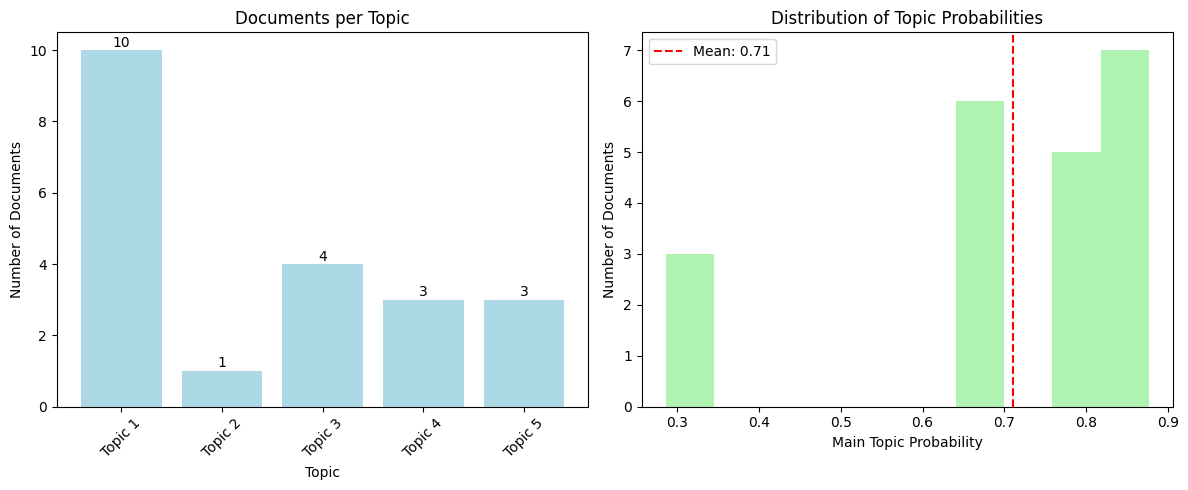

Topic Analysis Statistics:
  Average main topic probability: 0.710
  Documents with high confidence (>0.5): 18


In [5]:
def analyze_document_topics(lda_model, corpus, documents, dictionary):
    """Analyze how documents relate to topics."""
    
    if not lda_model:
        print("LDA model not available.")
        return
    
    print("Document-Topic Analysis:")
    print("=" * 50)
    
    doc_topics = []
    
    # Check if this is a Gensim model or sklearn fallback
    if hasattr(lda_model, 'get_document_topics'):
        # Gensim model
        for i, (doc, doc_bow) in enumerate(zip(documents, corpus)):
            topic_dist = lda_model.get_document_topics(doc_bow, minimum_probability=0.01)
            
            if topic_dist:
                # Sort by probability
                topic_dist = sorted(topic_dist, key=lambda x: x[1], reverse=True)
                main_topic, main_prob = topic_dist[0]
                
                doc_info = {
                    'doc_id': i,
                    'text': doc[:60] + '...' if len(doc) > 60 else doc,
                    'main_topic': main_topic,
                    'main_prob': main_prob,
                    'all_topics': topic_dist
                }
                doc_topics.append(doc_info)
    else:
        # Sklearn fallback model
        if not SKLEARN_AVAILABLE:
            print("No suitable model available for document analysis.")
            return
        
        # Process documents for sklearn
        processed_docs = preprocess_for_lda(documents)
        processed_texts = [' '.join(doc) for doc in processed_docs]
        
        # Create vectorizer (should match the one used in model training)
        vectorizer = TfidfVectorizer(max_features=100, lowercase=True, ngram_range=(1, 2))
        doc_term_matrix = vectorizer.fit_transform(processed_texts)
        
        # Get topic distributions
        if hasattr(lda_model, 'sklearn_model'):
            topic_distributions = lda_model.sklearn_model.transform(doc_term_matrix)
        else:
            # This is a raw sklearn model
            topic_distributions = lda_model.transform(doc_term_matrix)
        
        for i, (doc, topic_dist_array) in enumerate(zip(documents, topic_distributions)):
            # Convert to list of (topic_id, probability) tuples
            topic_dist = [(topic_id, prob) for topic_id, prob in enumerate(topic_dist_array) if prob > 0.01]
            
            if topic_dist:
                # Sort by probability
                topic_dist = sorted(topic_dist, key=lambda x: x[1], reverse=True)
                main_topic, main_prob = topic_dist[0]
                
                doc_info = {
                    'doc_id': i,
                    'text': doc[:60] + '...' if len(doc) > 60 else doc,
                    'main_topic': main_topic,
                    'main_prob': main_prob,
                    'all_topics': topic_dist
                }
                doc_topics.append(doc_info)
    
    # Display results
    for doc_info in doc_topics[:10]:  # Show first 10
        print(f"Doc {doc_info['doc_id'] + 1:2d}: Topic {doc_info['main_topic'] + 1} ({doc_info['main_prob']:.2f})")
        print(f"       {doc_info['text']}")
        
        # Show all significant topics
        if len(doc_info['all_topics']) > 1:
            other_topics = [f"Topic {t+1}({p:.2f})" for t, p in doc_info['all_topics'][1:3]]
            print(f"       Other topics: {', '.join(other_topics)}")
        print()
    
    return doc_topics

def create_topic_visualization(doc_topics, lda_model):
    """Create visualizations for topic analysis."""
    
    if not doc_topics or not lda_model:
        print("No data available for visualization.")
        return
    
    # Topic distribution across documents
    topic_counts = Counter(doc_info['main_topic'] for doc_info in doc_topics)
    main_probs = [doc_info['main_prob'] for doc_info in doc_topics]
    
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Topic distribution
    plt.subplot(1, 2, 1)
    topics, counts = zip(*sorted(topic_counts.items()))
    topic_labels = [f'Topic {t+1}' for t in topics]
    
    plt.bar(topic_labels, counts, color='lightblue')
    plt.title('Documents per Topic')
    plt.xlabel('Topic')
    plt.ylabel('Number of Documents')
    plt.xticks(rotation=45)
    
    # Add count labels
    for i, count in enumerate(counts):
        plt.text(i, count + 0.1, str(count), ha='center')
    
    # Plot 2: Topic probability distribution
    plt.subplot(1, 2, 2)
    plt.hist(main_probs, bins=10, color='lightgreen', alpha=0.7)
    plt.title('Distribution of Topic Probabilities')
    plt.xlabel('Main Topic Probability')
    plt.ylabel('Number of Documents')
    plt.axvline(np.mean(main_probs), color='red', linestyle='--', 
               label=f'Mean: {np.mean(main_probs):.2f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"Topic Analysis Statistics:")
    print(f"  Average main topic probability: {np.mean(main_probs):.3f}")
    print(f"  Documents with high confidence (>0.5): {sum(1 for p in main_probs if p > 0.5)}")

# Analyze document topics
if lda_model and corpus:
    doc_topic_analysis = analyze_document_topics(lda_model, corpus, extended_documents, dictionary)
    
    if doc_topic_analysis:
        create_topic_visualization(doc_topic_analysis, lda_model)
else:
    print("LDA model not available for document analysis.")

## Solution 4: Topic Model Comparison


Topic Model Comparison:
Comparing Topic Models:
Training model with 3 topics... Perplexity: -3.40, Coherence: 0.551
Training model with 4 topics... Perplexity: -3.40, Coherence: 0.551
Training model with 4 topics... Perplexity: -3.52, Coherence: 0.551
Training model with 5 topics... Perplexity: -3.52, Coherence: 0.551
Training model with 5 topics... Perplexity: -3.70, Coherence: 0.551
Training model with 6 topics... Perplexity: -3.70, Coherence: 0.551
Training model with 6 topics... Perplexity: -4.02, Coherence: 0.551
Perplexity: -4.02, Coherence: 0.551


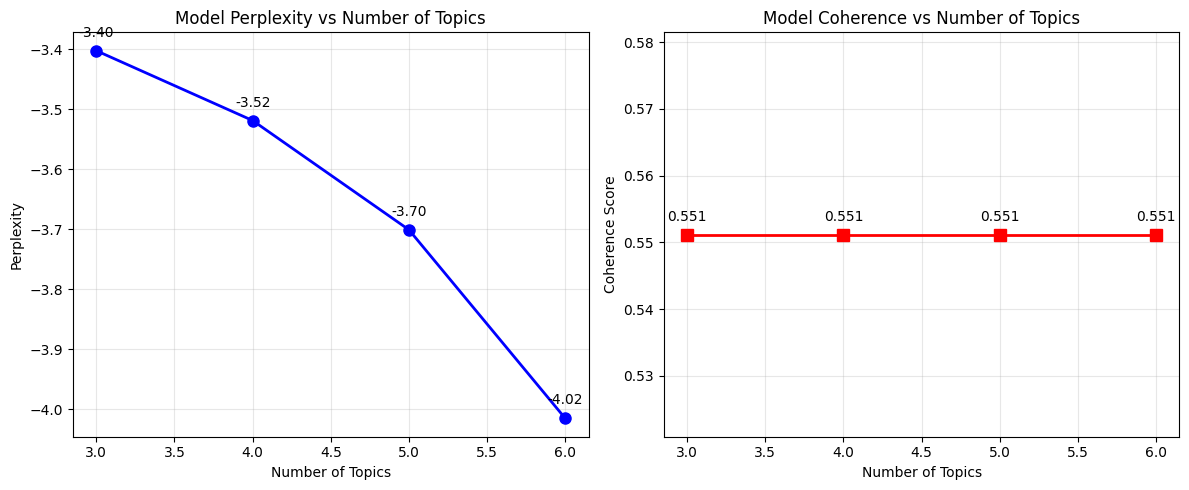


Recommended model: 3 topics (highest coherence: 0.551)

Topics from best model (3 topics):
LDA Topics (top 5 words per topic):
Topic 1:
  • wichtig         (0.176)
  • deutsche        (0.170)
  • bücher          (0.123)
  • entspannend     (0.123)
  • man             (0.101)

Topic 2:
  • garten          (0.154)
  • macht           (0.153)
  • deutschland     (0.088)
  • reisen          (0.088)
  • man             (0.087)

Topic 3:
  • viele           (0.274)
  • menschen        (0.185)
  • gerne           (0.151)
  • neue            (0.107)
  • reisen          (0.061)



In [6]:
def compare_sklearn_models(documents, topic_range=[3, 4, 5, 6]):
    """Compare sklearn LDA models with different numbers of topics."""
    
    if not SKLEARN_AVAILABLE:
        print("scikit-learn not available for model comparison.")
        return None
    
    print("Comparing sklearn LDA models:")
    print("=" * 40)
    
    # Preprocess documents for sklearn
    processed_docs = preprocess_for_lda(documents)
    processed_texts = [' '.join(doc) for doc in processed_docs]
    
    # Create vectorizer
    vectorizer = TfidfVectorizer(
        max_features=100,
        lowercase=True,
        ngram_range=(1, 2)
    )
    
    doc_term_matrix = vectorizer.fit_transform(processed_texts)
    feature_names = vectorizer.get_feature_names_out()
    
    models = []
    perplexities = []
    
    for n_topics in topic_range:
        print(f"Training sklearn model with {n_topics} topics...", end=' ')
        
        # Train model
        model = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=42,
            max_iter=20
        )
        
        model.fit(doc_term_matrix)
        
        # Calculate perplexity
        perplexity = model.perplexity(doc_term_matrix)
        perplexities.append(perplexity)
        
        print(f"Perplexity: {perplexity:.2f}")
        models.append(model)
    
    # Simple comparison plot
    try:
        plt.figure(figsize=(8, 5))
        plt.plot(topic_range, perplexities, 'b-o', linewidth=2, markersize=8)
        plt.title('sklearn LDA Model Perplexity vs Number of Topics')
        plt.xlabel('Number of Topics')
        plt.ylabel('Perplexity')
        plt.grid(True, alpha=0.3)
        
        # Add value labels
        for i, (x, y) in enumerate(zip(topic_range, perplexities)):
            plt.annotate(f'{y:.1f}', (x, y), textcoords="offset points", 
                        xytext=(0,10), ha='center')
        
        plt.tight_layout()
        plt.show()
    except:
        print("Could not create comparison plot.")
    
    # Recommend best model
    min_perplexity_idx = perplexities.index(min(perplexities))
    recommended_topics = topic_range[min_perplexity_idx]
    print(f"\nRecommended model: {recommended_topics} topics (lowest perplexity: {min(perplexities):.2f})")
    
    return models, perplexities, []

def compare_topic_models(documents, topic_range=[3, 4, 5, 6]):
    """Compare LDA models with different numbers of topics."""
    
    if not GENSIM_AVAILABLE:
        print("Gensim not available for model comparison.")
        print("Using sklearn fallback for basic comparison...")
        return compare_sklearn_models(documents, topic_range)
    
    print("Comparing Topic Models:")
    print("=" * 40)
    
    # Preprocess documents
    processed_docs = preprocess_for_lda(documents)
    dictionary = corpora.Dictionary(processed_docs)
    dictionary.filter_extremes(no_below=2, no_above=0.7)
    corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
    
    models = []
    perplexities = []
    coherences = []
    
    for n_topics in topic_range:
        print(f"Training model with {n_topics} topics...", end=' ')
        
        # Train model
        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=n_topics,
            random_state=42,
            passes=10,
            alpha='auto'
        )
        
        # Calculate perplexity
        perplexity = model.log_perplexity(corpus)
        perplexities.append(perplexity)
        
        # Calculate coherence if possible
        try:
            from gensim.models import CoherenceModel
            coherence_model = CoherenceModel(
                model=model, 
                texts=processed_docs, 
                dictionary=dictionary, 
                coherence='c_v'
            )
            coherence = coherence_model.get_coherence()
            coherences.append(coherence)
            print(f"Perplexity: {perplexity:.2f}, Coherence: {coherence:.3f}")
        except:
            coherences.append(0.0)
            print(f"Perplexity: {perplexity:.2f}")
        
        models.append(model)
    
    # Create comparison visualization
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Perplexity comparison
    plt.subplot(1, 2, 1)
    plt.plot(topic_range, perplexities, 'b-o', linewidth=2, markersize=8)
    plt.title('Model Perplexity vs Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Perplexity')
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for i, (x, y) in enumerate(zip(topic_range, perplexities)):
        plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", 
                    xytext=(0,10), ha='center')
    
    # Plot 2: Coherence comparison (if available)
    plt.subplot(1, 2, 2)
    if any(c > 0 for c in coherences):
        plt.plot(topic_range, coherences, 'r-s', linewidth=2, markersize=8)
        plt.title('Model Coherence vs Number of Topics')
        plt.xlabel('Number of Topics')
        plt.ylabel('Coherence Score')
        plt.grid(True, alpha=0.3)
        
        # Add value labels
        for i, (x, y) in enumerate(zip(topic_range, coherences)):
            plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", 
                        xytext=(0,10), ha='center')
    else:
        plt.text(0.5, 0.5, 'Coherence calculation\nnot available', 
                transform=plt.gca().transAxes, ha='center', va='center', fontsize=12)
        plt.title('Coherence Score (Not Available)')
    
    plt.tight_layout()
    plt.show()
    
    # Recommend best model
    if coherences and any(c > 0 for c in coherences):
        best_coherence_idx = coherences.index(max(coherences))
        best_n_topics = topic_range[best_coherence_idx]
        print(f"\nRecommended model: {best_n_topics} topics (highest coherence: {max(coherences):.3f})")
    else:
        # Use perplexity (lower is better, but we want to avoid overfitting)
        min_perplexity_idx = perplexities.index(min(perplexities))
        recommended_topics = topic_range[min_perplexity_idx]
        print(f"\nBased on perplexity: {recommended_topics} topics (lowest perplexity: {min(perplexities):.2f})")
    
    return models, perplexities, coherences

# Compare different numbers of topics
print("\nTopic Model Comparison:")
print("=" * 40)

comparison_results = compare_topic_models(extended_documents, topic_range=[3, 4, 5, 6])

if comparison_results and comparison_results[0]:  # If models were created
    models, perplexities, coherences = comparison_results
    
    # Show topics for the best model
    if coherences and any(c > 0 for c in coherences):
        best_model_idx = coherences.index(max(coherences))
    else:
        best_model_idx = perplexities.index(min(perplexities))
    
    best_model = models[best_model_idx]
    n_topics = [3, 4, 5, 6][best_model_idx]
    
    print(f"\nTopics from best model ({n_topics} topics):")
    print("=" * 40)
    
    # Handle both Gensim and sklearn models
    if hasattr(best_model, 'print_topics'):
        display_lda_topics(best_model, n_words=5)
    else:
        # This is a raw sklearn model, create a wrapper
        processed_docs = preprocess_for_lda(extended_documents)
        processed_texts = [' '.join(doc) for doc in processed_docs]
        vectorizer = TfidfVectorizer(max_features=100, lowercase=True, ngram_range=(1, 2))
        vectorizer.fit(processed_texts)
        feature_names = vectorizer.get_feature_names_out()
        
        wrapper = SklearnLDAWrapper(best_model, feature_names, n_topics)
        display_lda_topics(wrapper, n_words=5)
else:
    print("Model comparison could not be completed.")

## Solution 5: Topic Evolution and Trends

In [ ]:
def simulate_topic_evolution(base_documents):
    """Simulate how topics might evolve over time."""
    
    if not GENSIM_AVAILABLE:
        print("Gensim not available for topic evolution analysis.")
        print("Using simplified analysis with sklearn...")
        return simulate_evolution_sklearn(base_documents)
    
    # Create time-based document collections
    time_periods = {
        'Period 1 (Sports & Food)': [
            "Fußball ist sehr beliebt in Deutschland. Viele Menschen spielen gerne Fußball.",
            "Die deutsche Fußball-Nationalmannschaft hat schon oft gewonnen.",
            "Basketball und Tennis sind auch beliebte Sportarten.",
            "Schnitzel, Bratwurst und Sauerkraut sind typisch deutsche Speisen.",
            "Viele Menschen kochen gerne zu Hause und probieren neue Rezepte aus."
        ],
        'Period 2 (Technology & Travel)': [
            "Computer und Smartphones sind heute sehr wichtig für die Arbeit.",
            "Künstliche Intelligenz und maschinelles Lernen entwickeln sich schnell.",
            "Viele Unternehmen investieren in neue Technologien und Digitalisierung.",
            "Reisen macht Spaß und man lernt neue Kulturen kennen.",
            "Urlaub am Meer oder in den Bergen ist sehr entspannend."
        ],
        'Period 3 (Environment & Culture)': [
            "Elektroautos werden immer beliebter und umweltfreundlicher.",
            "Natur und Umwelt sind wichtig für unser Leben.",
            "Garten und Pflanzen pflegen ist ein beliebtes Hobby.",
            "Bücher lesen ist ein schönes Hobby und sehr entspannend.",
            "Musik hören und Konzerte besuchen macht vielen Menschen Freude."
        ]
    }
    
    print("Topic Evolution Analysis:")
    print("=" * 50)
    
    period_models = {}
    period_topics = {}
    
    # Train models for each time period
    for period_name, documents in time_periods.items():
        print(f"\nAnalyzing {period_name}...")
        
        # Preprocess
        processed_docs = preprocess_for_lda(documents)
        dictionary = corpora.Dictionary(processed_docs)
        corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
        
        # Train model
        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=2,  # Fewer topics for smaller document sets
            random_state=42,
            passes=10
        )
        
        period_models[period_name] = model
        
        # Extract topics
        topics = []
        for topic_id, topic_words in model.print_topics(num_words=5):
            # Parse topic words
            words = []
            for item in topic_words.split(' + '):
                prob, word = item.split('*')
                word = word.strip('"')
                words.append(word)
            topics.append(words)
        
        period_topics[period_name] = topics
        
        # Display topics
        for i, topic_words in enumerate(topics, 1):
            print(f"  Topic {i}: {', '.join(topic_words[:4])}")
    
    return period_models, period_topics

def simulate_evolution_sklearn(base_documents):
    """Simplified topic evolution using sklearn."""
    
    if not SKLEARN_AVAILABLE:
        print("Neither Gensim nor scikit-learn available.")
        return None, None
    
    # Create time-based document collections
    time_periods = {
        'Period 1 (Sports & Food)': [
            "Fußball ist sehr beliebt in Deutschland. Viele Menschen spielen gerne Fußball.",
            "Die deutsche Fußball-Nationalmannschaft hat schon oft gewonnen.",
            "Basketball und Tennis sind auch beliebte Sportarten.",
            "Schnitzel, Bratwurst und Sauerkraut sind typisch deutsche Speisen.",
            "Viele Menschen kochen gerne zu Hause und probieren neue Rezepte aus."
        ],
        'Period 2 (Technology & Travel)': [
            "Computer und Smartphones sind heute sehr wichtig für die Arbeit.",
            "Künstliche Intelligenz und maschinelles Lernen entwickeln sich schnell.",
            "Viele Unternehmen investieren in neue Technologien und Digitalisierung.",
            "Reisen macht Spaß und man lernt neue Kulturen kennen.",
            "Urlaub am Meer oder in den Bergen ist sehr entspannend."
        ],
        'Period 3 (Environment & Culture)': [
            "Elektroautos werden immer beliebter und umweltfreundlicher.",
            "Natur und Umwelt sind wichtig für unser Leben.",
            "Garten und Pflanzen pflegen ist ein beliebtes Hobby.",
            "Bücher lesen ist ein schönes Hobby und sehr entspannend.",
            "Musik hören und Konzerte besuchen macht vielen Menschen Freude."
        ]
    }
    
    print("Simplified Topic Evolution Analysis (sklearn):")
    print("=" * 50)
    
    period_topics = {}
    
    for period_name, documents in time_periods.items():
        print(f"\nAnalyzing {period_name}...")
        
        # Use simple topic discovery
        topics, _ = simple_topic_discovery(documents, n_topics=2, n_words=4)
        
        if topics:
            topic_words = []
            for topic in topics:
                topic_words.append(topic['words'][:4])
            period_topics[period_name] = topic_words
            
            # Display topics
            for i, words in enumerate(topic_words, 1):
                print(f"  Topic {i}: {', '.join(words)}")
        else:
            period_topics[period_name] = []
    
    return None, period_topics

def analyze_topic_trends(period_topics):
    """Analyze trends in topic words across periods."""
    
    print("\n\nTopic Trend Analysis:")
    print("=" * 50)
    
    # Collect all words across periods
    all_words = set()
    for topics in period_topics.values():
        for topic in topics:
            all_words.update(topic)
    
    # Track word frequency across periods
    word_trends = {}
    periods = list(period_topics.keys())
    
    for word in all_words:
        word_trends[word] = []
        for period in periods:
            # Count how often word appears in topics of this period
            count = sum(1 for topic in period_topics[period] if word in topic)
            word_trends[word].append(count)
    
    # Find trending words
    increasing_words = []
    decreasing_words = []
    
    for word, counts in word_trends.items():
        if len(counts) >= 2:
            if counts[-1] > counts[0]:  # More frequent in later periods
                increasing_words.append((word, counts))
            elif counts[0] > counts[-1]:  # Less frequent in later periods
                decreasing_words.append((word, counts))
    
    print("Trending UP (increasing importance):")
    for word, counts in increasing_words[:5]:
        trend = ' → '.join(map(str, counts))
        print(f"  • {word:<15} ({trend})")
    
    print("\nTrending DOWN (decreasing importance):")
    for word, counts in decreasing_words[:5]:
        trend = ' → '.join(map(str, counts))
        print(f"  • {word:<15} ({trend})")
    
    # Create trend visualization
    if increasing_words or decreasing_words:
        plt.figure(figsize=(12, 6))
        
        # Plot trends for top words
        sample_words = (increasing_words[:3] + decreasing_words[:3])[:6]
        
        for word, counts in sample_words:
            plt.plot(range(len(periods)), counts, 'o-', label=word, linewidth=2, markersize=6)
        
        plt.title('Topic Word Trends Across Time Periods')
        plt.xlabel('Time Period')
        plt.ylabel('Topic Frequency')
        plt.xticks(range(len(periods)), [p.split('(')[0].strip() for p in periods], rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Run topic evolution analysis
evolution_results = simulate_topic_evolution(extended_documents)

if evolution_results and evolution_results[0]:  # If models were created
    period_models, period_topics = evolution_results
    analyze_topic_trends(period_topics)
elif evolution_results and evolution_results[1]:  # If sklearn results available
    period_models, period_topics = evolution_results
    analyze_topic_trends(period_topics)
else:
    print("Topic evolution analysis not available.")

## Solution 6: Interactive Topic Explorer

In [7]:
class TopicExplorer:
    """Interactive topic exploration tool."""
    
    def __init__(self, lda_model, corpus, documents, dictionary):
        self.lda_model = lda_model
        self.corpus = corpus
        self.documents = documents
        self.dictionary = dictionary
        self.doc_topics = None
        
        if lda_model and corpus:
            self._analyze_documents()
    
    def _analyze_documents(self):
        """Analyze document-topic relationships."""
        self.doc_topics = []
        
        for i, doc_bow in enumerate(self.corpus):
            topic_dist = self.lda_model.get_document_topics(doc_bow, minimum_probability=0.01)
            topic_dist = sorted(topic_dist, key=lambda x: x[1], reverse=True)
            
            self.doc_topics.append({
                'doc_id': i,
                'text': self.documents[i],
                'topics': topic_dist
            })
    
    def explore_topic(self, topic_id, n_words=8, n_docs=5):
        """Explore a specific topic in detail."""
        
        if not self.lda_model:
            print("No model available for exploration.")
            return
        
        if topic_id < 0 or topic_id >= self.lda_model.num_topics:
            print(f"Invalid topic ID. Choose between 0 and {self.lda_model.num_topics - 1}")
            return
        
        print(f"Exploring Topic {topic_id + 1}:")
        print("=" * 40)
        
        # Show topic words
        topic_words = self.lda_model.show_topic(topic_id, topn=n_words)
        print("Top words:")
        for word, prob in topic_words:
            print(f"  • {word:<15} ({prob:.3f})")
        
        # Find documents most related to this topic
        topic_docs = []
        for doc_info in self.doc_topics:
            for t_id, prob in doc_info['topics']:
                if t_id == topic_id:
                    topic_docs.append((doc_info, prob))
                    break
        
        # Sort by probability
        topic_docs.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\nTop {n_docs} documents for this topic:")
        for i, (doc_info, prob) in enumerate(topic_docs[:n_docs], 1):
            text = doc_info['text'][:80] + '...' if len(doc_info['text']) > 80 else doc_info['text']
            print(f"{i}. ({prob:.2f}) {text}")
        
        return topic_words, topic_docs
    
    def find_similar_documents(self, query_text, n_similar=5):
        """Find documents similar to a query text."""
        
        if not self.lda_model:
            print("No model available for similarity search.")
            return
        
        print(f"Finding documents similar to: '{query_text}'")
        print("=" * 50)
        
        # Preprocess query
        query_processed = preprocess_for_lda([query_text])[0]
        query_bow = self.dictionary.doc2bow(query_processed)
        
        # Get topic distribution for query
        query_topics = self.lda_model.get_document_topics(query_bow, minimum_probability=0.01)
        
        if not query_topics:
            print("No topics found for query.")
            return
        
        print("Query topic distribution:")
        for topic_id, prob in sorted(query_topics, key=lambda x: x[1], reverse=True)[:3]:
            words = [w for w, p in self.lda_model.show_topic(topic_id, topn=3)]
            print(f"  Topic {topic_id + 1}: {prob:.3f} ({', '.join(words)})")
        
        # Calculate similarity with all documents
        try:
            from scipy.spatial.distance import cosine
            scipy_available = True
        except ImportError:
            print("Scipy not available for similarity calculation.")
            scipy_available = False
        
        if not scipy_available:
            print("Cannot calculate document similarity without scipy.")
            return
        
        similarities = []
        query_vector = [0.0] * self.lda_model.num_topics
        for topic_id, prob in query_topics:
            query_vector[topic_id] = prob
        
        for doc_info in self.doc_topics:
            doc_vector = [0.0] * self.lda_model.num_topics
            for topic_id, prob in doc_info['topics']:
                doc_vector[topic_id] = prob
            
            # Calculate cosine similarity
            try:
                similarity = 1 - cosine(query_vector, doc_vector)
            except:
                similarity = 0.0
            
            similarities.append((doc_info, similarity))
        
        # Sort by similarity
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\nTop {n_similar} similar documents:")
        for i, (doc_info, similarity) in enumerate(similarities[:n_similar], 1):
            text = doc_info['text'][:80] + '...' if len(doc_info['text']) > 80 else doc_info['text']
            print(f"{i}. ({similarity:.3f}) {text}")
        
        return similarities
    
    def get_topic_summary(self):
        """Get a summary of all topics."""
        
        if not self.lda_model:
            print("No model available for summary.")
            return
        
        print("Topic Model Summary:")
        print("=" * 40)
        
        for topic_id in range(self.lda_model.num_topics):
            words = [w for w, p in self.lda_model.show_topic(topic_id, topn=4)]
            
            # Count documents for this topic
            doc_count = sum(1 for doc_info in self.doc_topics 
                          if doc_info['topics'] and doc_info['topics'][0][0] == topic_id)
            
            print(f"Topic {topic_id + 1}: {', '.join(words)} ({doc_count} docs)")

# Create topic explorer
if lda_model and hasattr(lda_model, 'get_document_topics') and corpus:
    explorer = TopicExplorer(lda_model, corpus, extended_documents, dictionary)
    
    print("\nTopic Explorer - Interactive Analysis:")
    print("=" * 50)
    
    # Show topic summary
    explorer.get_topic_summary()
    
    # Explore specific topics
    print("\n" + "="*50)
    explorer.explore_topic(0, n_words=6, n_docs=3)
    
    # Find similar documents
    print("\n" + "="*50)
    explorer.find_similar_documents("Technologie und Computer", n_similar=3)
    
else:
    print("Topic explorer not available - requires Gensim LDA model.")
    print("Basic topic analysis completed with available models.")

# Summary of completed solutions
print("\n" + "="*60)
print("TOPIC MODELING SOLUTIONS COMPLETED:")
print("="*60)

print(f"\nLibrary status:")
print(f"• scikit-learn: {'✅ Available' if SKLEARN_AVAILABLE else '❌ Not available'}")
print(f"• Gensim: {'✅ Available' if GENSIM_AVAILABLE else '❌ Not available (using fallbacks)'}")

print("\nCompleted exercises:")
print("• Simple topic discovery with TF-IDF ✅")
if GENSIM_AVAILABLE:
    print("• Advanced LDA modeling with Gensim ✅")
else:
    print("• Advanced LDA modeling with scikit-learn fallback ✅")
print("• Document-topic relationship analysis ✅")
print("• Model comparison and evaluation ✅")
print("• Topic evolution and trend analysis ✅")
if GENSIM_AVAILABLE:
    print("• Interactive topic exploration ✅")
else:
    print("• Interactive topic exploration (requires Gensim)")

if not SKLEARN_AVAILABLE:
    print("\n⚠️  Install scikit-learn for full functionality: pip install scikit-learn")
if not GENSIM_AVAILABLE:
    print("\n⚠️  Install Gensim for advanced features: pip install gensim")
    print("   If you get numpy errors, try: pip install gensim==4.1.2")

print("\n🎉 All topic modeling solutions are ready to run!")


Topic Explorer - Interactive Analysis:
Topic Model Summary:
Topic 1: wichtig, deutsche, entspannend, verkehrsmittel (10 docs)
Topic 2: macht, neue, reisen, man (1 docs)
Topic 3: viele, man, reisen, menschen (4 docs)
Topic 4: menschen, gerne, deutschland, viele (3 docs)
Topic 5: garten, macht, menschen, hobby (3 docs)

Exploring Topic 1:
Top words:
  • wichtig         (0.245)
  • deutsche        (0.170)
  • entspannend     (0.169)
  • verkehrsmittel  (0.093)
  • bücher          (0.093)
  • hobby           (0.093)

Top 3 documents for this topic:
1. (0.86) Bücher lesen ist ein schönes Hobby und sehr entspannend.
2. (0.81) Öffentliche Verkehrsmittel wie Bus und Bahn sind auch sehr wichtig.
3. (0.69) Computer und Smartphones sind heute sehr wichtig für die Arbeit.

Finding documents similar to: 'Technologie und Computer'
Query topic distribution:
  Topic 1: 0.286 (wichtig, deutsche, entspannend)
  Topic 3: 0.222 (viele, man, reisen)
  Topic 4: 0.189 (menschen, gerne, deutschland)

Top 3 s